In [1]:
# Imports

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import hvplot.pandas
import plotly.express as px
from pathlib import Path
import os
import calendar
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA
from arch import arch_model
import numpy as np
from statsmodels.tsa.arima_model import ARIMA
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns


Bad key "text.kerning_factor" on line 4 in
C:\Users\Sravani\anaconda3\envs\pyvizenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
# Assign path and get the data
csv_path = Path("seattle-neighborhoods.csv")
df = pd.read_csv(csv_path)

In [3]:
# Fil Null Values
df = df.fillna(method="pad")

In [4]:
# Create dataframe for neighborhoods and clean up

neighborhood_df = df.drop(df[df["Region"] == "Seattle, WA"].index)
neighborhood_df["Region"] = neighborhood_df["Region"].str.split("-")
neighborhood_df["Region"] = neighborhood_df["Region"].str[1]
neighborhood_df.set_index("Region", inplace=True)
pd.to_datetime(neighborhood_df["Month of Period End"])
neighborhood_df.head()

,Month of Period End,Median Sale Price,Median Sale Price MoM,Median Sale Price YoY,Homes Sold,Homes Sold MoM,Homes Sold YoY,New Listings,New Listings MoM,New Listings YoY,Inventory,Inventory MoM,Inventory YoY,Days on Market,Days on Market MoM,Days on Market YoY,Average Sale To List,Average Sale To List MoM,Average Sale To List YoY
Region,,,,,,,,,,,,,,,,,,,
Adams,February 2012,$348K,-0.7%,3.7%,40,-7.0%,25.0%,28,-15.2%,-37.8%,30,-3.2%,-37.5%,40.0,-10.0,-17.0,98.6%,0.2%,1.0%
Adams,March 2012,$347K,-0.1%,4.4%,40,0.0%,11.1%,43,53.6%,-33.8%,25,-16.7%,-50.0%,49.0,10.0,-6.0,98.6%,-0.1%,0.3%
Adams,April 2012,$325K,-6.3%,-6.7%,47,17.5%,6.8%,65,51.2%,20.4%,37,48.0%,-22.9%,46.0,-4.0,27.0,98.7%,0.2%,0.1%
Adams,May 2012,$332K,2.0%,-8.4%,56,19.1%,21.7%,71,9.2%,26.8%,32,-13.5%,-37.3%,37.0,-9.0,8.0,99.2%,0.4%,0.7%
Adams,June 2012,$328K,-1.1%,-2.2%,63,12.5%,61.5%,68,-4.2%,41.7%,25,-21.9%,-50.0%,16.0,-21.0,-23.0,99.0%,-0.2%,-0.6%


In [5]:
# Cleaning up special characters

dictionary = {'%':'', 'K':'', '\$' : '', ',' : ''} 
neighborhood_df.replace(dictionary, regex=True, inplace=True)

In [6]:
# Change data types

cols = [i for i in neighborhood_df.columns if i not in ["Region", "Month of Period End"]]
for col in cols:
    neighborhood_df[col]=pd.to_numeric(neighborhood_df[col])

In [7]:
# Editting column names

neighborhood_df.columns = ['Month_of_Period_End','Median_Sale_Price',
 'Median_Sale_Price_MoM',
 'Median_Sale_Price_YoY',
 'Homes_Sold',
 'Homes_Sold_MoM',
 'Homes_Sold_YoY',
 'New_Listings',
 'New_Listings_MoM',
 'New_Listings_YoY',
 'Inventory',
 'Inventory_MoM',
 ' Inventory_YoY',
 'Days_on_Market',
 'Days_on_Market_MoM',
 'Days_on_Market_YoY',
 'Average_Sale_To_List',
 'Average_Sale_To_List_MoM',
 'Average_Sale_To_List_YoY']

In [8]:
# Calulate standdard deviations

std_df = pd.DataFrame(neighborhood_df["Median_Sale_Price"])

std_df = std_df.groupby('Region').std()

std_df.sort_values(by=['Median_Sale_Price'], inplace = True)

std_df.tail()

,Median_Sale_Price
Region,
Laurelhurst,302.292079
Madison Park,316.805381
Portage Bay,327.792970
Seattle Central Business District,552.553940
Denny Blaine,638.997272


# Neighborhoods with low STD

# low std 1

In [9]:
#Getting neighborhood data

belltown_df = neighborhood_df.loc[neighborhood_df.index == " Belltown"]
belltown_df.reset_index(drop=True, inplace=True)
belltown_df.set_index("Month_of_Period_End", inplace = True)

In [10]:
# Check for stationarity
adfuller(belltown_df.Median_Sale_Price)

(-0.7513717688393351,
 0.8329907730802781,
 3,
 101,
 {'1%': -3.4968181663902103,
  '5%': -2.8906107514600103,
  '10%': -2.5822770483285953},
 833.365488387235)

In [11]:
# Change to statiory
belltown_df['Returns'] = belltown_df.Median_Sale_Price.pct_change()
belltown_df = belltown_df.dropna()

C:\Users\Sravani\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [12]:
# Divide data frames to see how the model performed

train = belltown_df.iloc[:94,:] 
test = belltown_df.iloc[95:,:]
# Create dataframe for predictions
Comparison_l1 = pd.DataFrame()

Comparison_l1["Original"] = (test.loc[:, 'Returns'])
Returns = train.loc[:, 'Returns']

In [13]:
# ARMA
model = ARMA(Returns.values, order=(1,1))
results = model.fit()

In [14]:
# Predict using ARMA model
predicted_arma = results.forecast(steps=9)[0]
Comparison_l1["Arma"] = predicted_arma

In [15]:
#ARIMA
model = ARIMA(Returns, order=(1, 1, 1))
results = model.fit()

C:\Users\Sravani\anaconda3\envs\pyvizenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Sravani\anaconda3\envs\pyvizenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [16]:
# PRedict using ARIMA
predicted_arima = results.forecast(steps=9)[0]
Comparison_l1["Arima"] = predicted_arma

In [17]:
# Garch model
model = arch_model(Returns, mean="Zero", vol="GARCH", p=1, q=1)
res = model.fit(disp="off")

C:\Users\Sravani\anaconda3\envs\pyvizenv\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.004452. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


In [18]:
# Forecast using Garch
forecast_horizon = 9
garch = res.forecast(horizon=forecast_horizon)
intermediate = np.sqrt(garch.variance.dropna() * 252)
final = intermediate.dropna().T
final.columns = ["Garch"]
final.index = Comparison_l1.index
Comparison_l1["Garch"] = final["Garch"]

In [19]:
Comparison_l1.hvplot().opts(xrotation=90)

:NdOverlay   [Variable]
   :Curve   [Month_of_Period_End]   (value)

In [20]:
# Picking data to calculate importances

X = belltown_df[["Homes_Sold", "New_Listings","Inventory", "Days_on_Market", "Average_Sale_To_List" ]].copy()
y = belltown_df["Median_Sale_Price"].ravel()
y[:5]

array([350, 358, 423, 419, 389], dtype=int64)

In [21]:
# Divide data for rf model
xtrain = X.iloc[:94,:] 
xtest = X.iloc[95:,:]

ytrain = y[0:94]
ytest = y[95::]


In [22]:
# Scale data
scaler = StandardScaler()

In [23]:
# Fit into scaling model
X_scaler = scaler.fit(xtrain)
X_train_scaled = X_scaler.transform(xtrain)
X_test_scaled = X_scaler.transform(xtest)

In [24]:
# Fit into rf model
rf_model = RandomForestClassifier(n_estimators=500, random_state=78)
rf_model = rf_model.fit(X_train_scaled, ytrain)
predictions = rf_model.predict(X_test_scaled)

In [25]:
# Declare variable for importances
importances = rf_model.feature_importances_

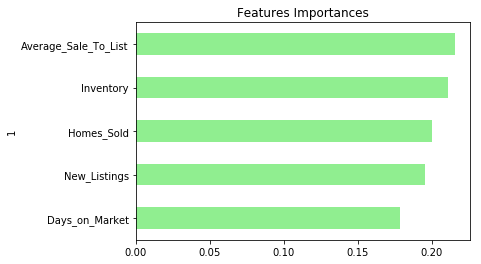

In [26]:
# Visualize importances
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)


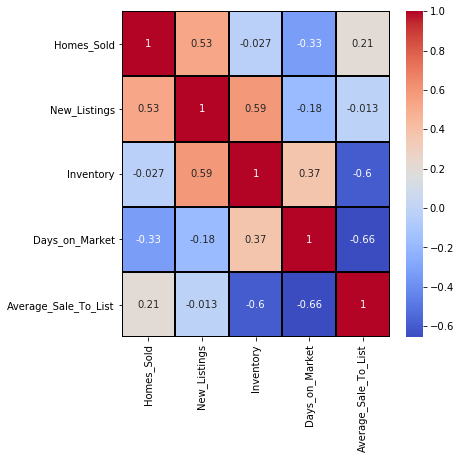

In [27]:
# Plot correlations
fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm', linewidth=1, linecolor='black')

# low std 2

In [28]:
broadway_df = neighborhood_df.loc[neighborhood_df.index == " Broadway"]
broadway_df.reset_index(drop=True, inplace=True)
broadway_df.set_index("Month_of_Period_End", inplace = True)

In [29]:
adfuller(broadway_df.Median_Sale_Price)

(-0.9342852020083348,
 0.7764722818571573,
 3,
 101,
 {'1%': -3.4968181663902103,
  '5%': -2.8906107514600103,
  '10%': -2.5822770483285953},
 840.6197626260614)

In [30]:
broadway_df['Returns'] = broadway_df.Median_Sale_Price.pct_change()
broadway_df = broadway_df.dropna()

C:\Users\Sravani\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [31]:
train = broadway_df.iloc[:94,:] 
test = broadway_df.iloc[95:,:]

Comparison_l2 = pd.DataFrame()
#Comparison.index = test.index
Comparison_l2["Original"] = (test.loc[:, 'Returns'])
Returns = train.loc[:, 'Returns']

In [32]:
model = ARMA(Returns.values, order=(1,1))
results = model.fit()

C:\Users\Sravani\anaconda3\envs\pyvizenv\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [33]:
predicted_arma = results.forecast(steps=9)[0]
Comparison_l2["Arma"] = predicted_arma

In [34]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(Returns, order=(1, 1, 1))
results = model.fit()

C:\Users\Sravani\anaconda3\envs\pyvizenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Sravani\anaconda3\envs\pyvizenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [35]:
predicted_arima = results.forecast(steps=9)[0]
Comparison_l2["Arima"] = predicted_arma

In [36]:
model = arch_model(Returns, mean="Zero", vol="GARCH", p=1, q=1)
res = model.fit(disp="off")

C:\Users\Sravani\anaconda3\envs\pyvizenv\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.003347. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


In [37]:
forecast_horizon = 9
garch = res.forecast(horizon=forecast_horizon)
intermediate = np.sqrt(garch.variance.dropna() * 252)
final = intermediate.dropna().T
final.columns = ["Garch"]
final.index = Comparison_l2.index
Comparison_l2["Garch"] = final["Garch"]

In [38]:
Comparison_l2.hvplot().opts(xrotation=90)

:NdOverlay   [Variable]
   :Curve   [Month_of_Period_End]   (value)

In [39]:
X = broadway_df[["Homes_Sold", "New_Listings","Inventory", "Days_on_Market", "Average_Sale_To_List" ]].copy()
y = broadway_df["Median_Sale_Price"].ravel()
y[:5]

array([260, 305, 315, 290, 289], dtype=int64)

In [40]:
xtrain = X.iloc[:94,:] 
xtest = X.iloc[95:,:]

ytrain = y[0:94]
ytest = y[95::]

In [41]:
scaler = StandardScaler()

In [42]:
X_scaler = scaler.fit(xtrain)
X_train_scaled = X_scaler.transform(xtrain)
X_test_scaled = X_scaler.transform(xtest)

In [43]:
rf_model = RandomForestClassifier(n_estimators=500, random_state=78)
rf_model = rf_model.fit(X_train_scaled, ytrain)
predictions = rf_model.predict(X_test_scaled)

In [44]:
importances = rf_model.feature_importances_

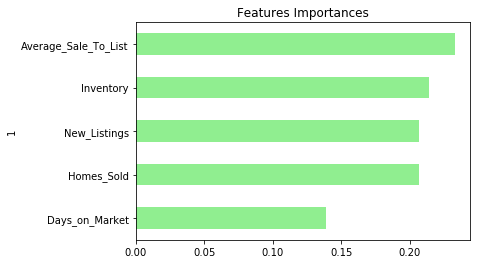

In [45]:
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)

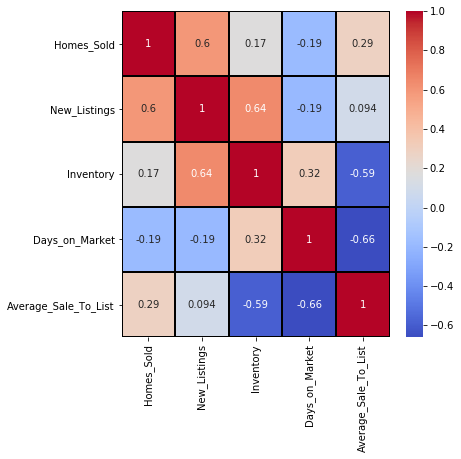

In [46]:
fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm', linewidth=1, linecolor='black')

# low std 3

In [47]:
internationaldistrict_df = neighborhood_df.loc[neighborhood_df.index == " International District"]
internationaldistrict_df.reset_index(drop=True, inplace=True)
internationaldistrict_df.set_index("Month_of_Period_End", inplace = True)

In [48]:
adfuller(internationaldistrict_df.Median_Sale_Price)

(-0.939163737712231,
 0.7748018833035709,
 6,
 86,
 {'1%': -3.5087828609430614,
  '5%': -2.895783561573195,
  '10%': -2.5850381719848565},
 920.2836691140046)

In [49]:
internationaldistrict_df['Returns'] = internationaldistrict_df.Median_Sale_Price.pct_change()
internationaldistrict_df = internationaldistrict_df.dropna()

C:\Users\Sravani\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [50]:
train = internationaldistrict_df.iloc[:84,:] 
test = internationaldistrict_df.iloc[85:,:]

Comparison_l3 = pd.DataFrame()
#Comparison.index = test.index
Comparison_l3["Original"] = (test.loc[:, 'Returns'])
Returns = train.loc[:, 'Returns']

In [51]:
model = ARMA(Returns.values, order=(1,1))
results = model.fit()

In [52]:
predicted_arma = results.forecast(steps=7)[0]
Comparison_l3["Arma"] = predicted_arma

In [53]:
model = ARIMA(Returns, order=(1, 1, 1))
results = model.fit()

C:\Users\Sravani\anaconda3\envs\pyvizenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Sravani\anaconda3\envs\pyvizenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [54]:
predicted_arima = results.forecast(steps=6)[0]
Comparison_l3["Arima"] = predicted_arma
Comparison_l3

,Original,Arma,Arima
Month_of_Period_End,,,
January 2020,0.065315,-0.048273,-0.048273
February 2020,-0.143763,-0.015296,-0.015296
March 2020,0.864198,0.004369,0.004369
July 2020,-0.609272,0.016096,0.016096
August 2020,0.000000,0.023090,0.023090
September 2020,0.566102,0.027260,0.027260
October 2020,-0.023810,0.029747,0.029747


In [55]:
model = arch_model(Returns, mean="Zero", vol="GARCH", p=1, q=1)
res = model.fit(disp="off")

C:\Users\Sravani\anaconda3\envs\pyvizenv\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05822. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


In [56]:
forecast_horizon = 7
garch = res.forecast(horizon=forecast_horizon)
intermediate = np.sqrt(garch.variance.dropna() * 252)
final = intermediate.dropna().T
final.columns = ["Garch"]
final.index = Comparison_l3.index
Comparison_l3["Garch"] = final["Garch"]

In [57]:
Comparison_l3.hvplot().opts(xrotation=90)

:NdOverlay   [Variable]
   :Curve   [Month_of_Period_End]   (value)

In [58]:
X = internationaldistrict_df[["Homes_Sold", "New_Listings","Inventory", "Days_on_Market", "Average_Sale_To_List" ]].copy()
y = internationaldistrict_df["Median_Sale_Price"].ravel()
y[:5]

array([160, 160, 160, 160, 110], dtype=int64)

In [59]:
xtrain = X.iloc[:84,:] 
xtest = X.iloc[85:,:]

ytrain = y[0:84]
ytest = y[85::]

In [60]:
scaler = StandardScaler()

In [61]:
X_scaler = scaler.fit(xtrain)
X_train_scaled = X_scaler.transform(xtrain)
X_test_scaled = X_scaler.transform(xtest)

In [62]:
rf_model = RandomForestClassifier(n_estimators=500, random_state=78)
rf_model = rf_model.fit(X_train_scaled, ytrain)
predictions = rf_model.predict(X_test_scaled)

In [63]:
importances = rf_model.feature_importances_

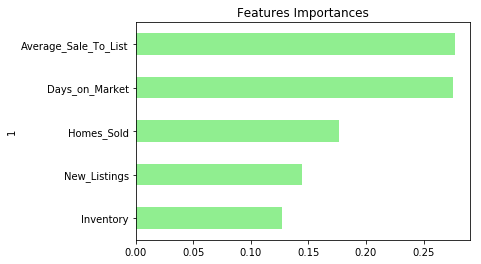

In [64]:
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)

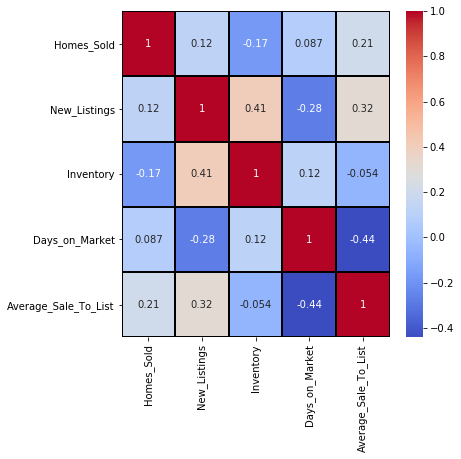

In [65]:
fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm', linewidth=1, linecolor='black')

# low std 4

In [66]:
pinehurst_df = neighborhood_df.loc[neighborhood_df.index == " Pinehurst"]
pinehurst_df.reset_index(drop=True, inplace=True)
pinehurst_df.set_index("Month_of_Period_End", inplace = True)

In [67]:
adfuller(pinehurst_df.Median_Sale_Price)

(-1.4583612833381765,
 0.5539997537537683,
 3,
 101,
 {'1%': -3.4968181663902103,
  '5%': -2.8906107514600103,
  '10%': -2.5822770483285953},
 933.8976620819795)

In [68]:
pinehurst_df['Returns'] = pinehurst_df.Median_Sale_Price.pct_change()
pinehurst_df = pinehurst_df.dropna()

C:\Users\Sravani\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [69]:
train = pinehurst_df.iloc[:94,:] 
test = pinehurst_df.iloc[95:,:]

Comparison_l4 = pd.DataFrame()
#Comparison.index = test.index
Comparison_l4["Original"] = (test.loc[:, 'Returns'])
Returns = train.loc[:, 'Returns']

In [70]:
model = ARMA(Returns.values, order=(1,1))
results = model.fit()

In [71]:
predicted_arma = results.forecast(steps=9)[0]
Comparison_l4["Arma"] = predicted_arma

In [72]:
model = ARIMA(Returns, order=(1, 1, 1))
results = model.fit()

C:\Users\Sravani\anaconda3\envs\pyvizenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Sravani\anaconda3\envs\pyvizenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [73]:
predicted_arima = results.forecast(steps=9)[0]
Comparison_l4["Arima"] = predicted_arma

In [74]:
model = arch_model(Returns, mean="Zero", vol="GARCH", p=1, q=1)
res = model.fit(disp="off")

C:\Users\Sravani\anaconda3\envs\pyvizenv\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.01249. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


In [75]:
forecast_horizon = 9
garch = res.forecast(horizon=forecast_horizon)
intermediate = np.sqrt(garch.variance.dropna() * 252)
final = intermediate.dropna().T
final.columns = ["Garch"]
final.index = Comparison_l4.index
Comparison_l4["Garch"] = final["Garch"]

In [76]:
Comparison_l4.hvplot().opts(xrotation=90)

:NdOverlay   [Variable]
   :Curve   [Month_of_Period_End]   (value)

In [77]:
X = pinehurst_df[["Homes_Sold", "New_Listings","Inventory", "Days_on_Market", "Average_Sale_To_List" ]].copy()
y = pinehurst_df["Median_Sale_Price"].ravel()
y[:5]

array([185, 242, 220, 228, 215], dtype=int64)

In [78]:
xtrain = X.iloc[:94,:] 
xtest = X.iloc[95:,:]

ytrain = y[0:94]
ytest = y[95::]

xtest

,Homes_Sold,New_Listings,Inventory,Days_on_Market,Average_Sale_To_List
Month_of_Period_End,,,,,
February 2020,10,7,1,115.0,98.4
March 2020,13,9,2,61.0,101.6
April 2020,12,14,3,91.0,102.1
May 2020,14,16,2,7.0,103.8
June 2020,16,22,5,7.0,102.0
July 2020,21,30,9,7.0,102.2
August 2020,19,30,6,6.0,103.3
September 2020,23,34,9,7.0,104.8
October 2020,27,32,12,7.0,104.0


In [79]:
scaler = StandardScaler()

In [80]:
X_scaler = scaler.fit(xtrain)
X_train_scaled = X_scaler.transform(xtrain)
X_test_scaled = X_scaler.transform(xtest)

In [81]:
rf_model = RandomForestClassifier(n_estimators=500, random_state=78)
rf_model = rf_model.fit(X_train_scaled, ytrain)
predictions = rf_model.predict(X_test_scaled)

In [82]:
importances = rf_model.feature_importances_

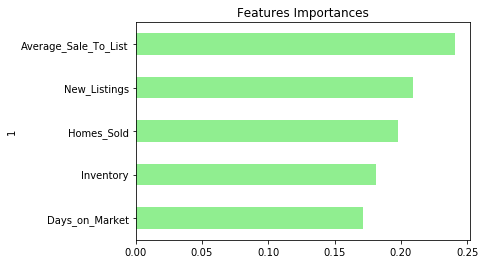

In [83]:
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)

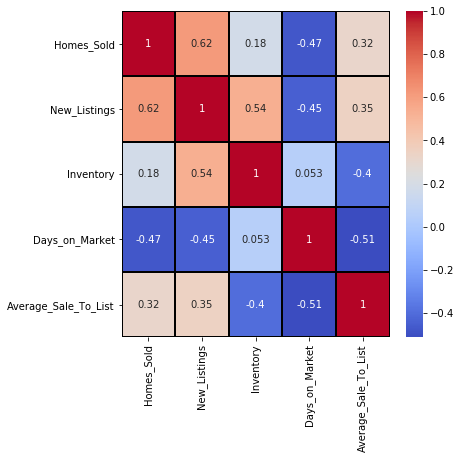

In [84]:
fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm', linewidth=1, linecolor='black')

# low std 5

In [85]:
dunlap_df = neighborhood_df.loc[neighborhood_df.index == " Dunlap"]
dunlap_df.reset_index(drop=True, inplace=True)
dunlap_df.set_index("Month_of_Period_End", inplace = True)

In [86]:
adfuller(dunlap_df.Median_Sale_Price)

(-0.678945933157321,
 0.85212790771233,
 8,
 96,
 {'1%': -3.5003788874873405,
  '5%': -2.8921519665075235,
  '10%': -2.5830997960069446},
 866.0623734966898)

In [87]:
dunlap_df['Returns'] = dunlap_df.Median_Sale_Price.pct_change()
dunlap_df = dunlap_df.dropna()

C:\Users\Sravani\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [88]:
train = dunlap_df.iloc[:94,:] 
test = dunlap_df.iloc[95:,:]

Comparison_l5 = pd.DataFrame()
#Comparison.index = test.index
Comparison_l5["Original"] = (test.loc[:, 'Returns'])
Returns = train.loc[:, 'Returns']
Comparison_l5

,Original
Month_of_Period_End,
February 2020,0.000000
March 2020,0.010204
April 2020,0.014141
May 2020,0.025896
June 2020,0.000000
July 2020,0.015534
August 2020,-0.028681
September 2020,-0.011811
October 2020,-0.013944


In [89]:
model = ARMA(Returns.values, order=(1,1))
results = model.fit()

In [90]:
predicted_arma = results.forecast(steps=9)[0]
Comparison_l5["Arma"] = predicted_arma
Comparison_l5

,Original,Arma
Month_of_Period_End,,
February 2020,0.000000,0.016761
March 2020,0.010204,0.018645
April 2020,0.014141,0.016883
May 2020,0.025896,0.018531
June 2020,0.000000,0.016990
July 2020,0.015534,0.018431
August 2020,-0.028681,0.017083
September 2020,-0.011811,0.018344
October 2020,-0.013944,0.017165


In [91]:
model = ARIMA(Returns, order=(1, 1, 1))
results = model.fit()

C:\Users\Sravani\anaconda3\envs\pyvizenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Sravani\anaconda3\envs\pyvizenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [92]:
predicted_arima = results.forecast(steps=9)[0]
Comparison_l5["Arima"] = predicted_arma

In [93]:
model = arch_model(Returns, mean="Zero", vol="GARCH", p=1, q=1)
res = model.fit(disp="off")

C:\Users\Sravani\anaconda3\envs\pyvizenv\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.01497. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


In [94]:
forecast_horizon = 9
garch = res.forecast(horizon=forecast_horizon)
intermediate = np.sqrt(garch.variance.dropna() * 252)
final = intermediate.dropna().T
final.columns = ["Garch"]
final.index = Comparison_l5.index
Comparison_l5["Garch"] = final["Garch"]

In [95]:
Comparison_l5.hvplot().opts(xrotation=90)

:NdOverlay   [Variable]
   :Curve   [Month_of_Period_End]   (value)

In [96]:
X = dunlap_df[["Homes_Sold", "New_Listings","Inventory", "Days_on_Market", "Average_Sale_To_List" ]].copy()
y = dunlap_df["Median_Sale_Price"].ravel()
y[:5]

array([189, 188, 204, 197, 207], dtype=int64)

In [97]:
xtrain = X.iloc[:94,:] 
xtest = X.iloc[95:,:]

ytrain = y[0:94]
ytest = y[95::]

In [98]:
scaler = StandardScaler()

In [99]:
X_scaler = scaler.fit(xtrain)
X_train_scaled = X_scaler.transform(xtrain)
X_test_scaled = X_scaler.transform(xtest)

In [100]:
rf_model = RandomForestClassifier(n_estimators=500, random_state=78)
rf_model = rf_model.fit(X_train_scaled, ytrain)
predictions = rf_model.predict(X_test_scaled)

In [101]:
importances = rf_model.feature_importances_

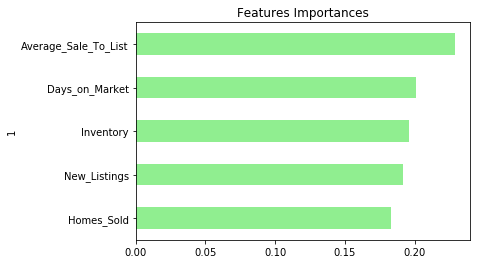

In [102]:
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)

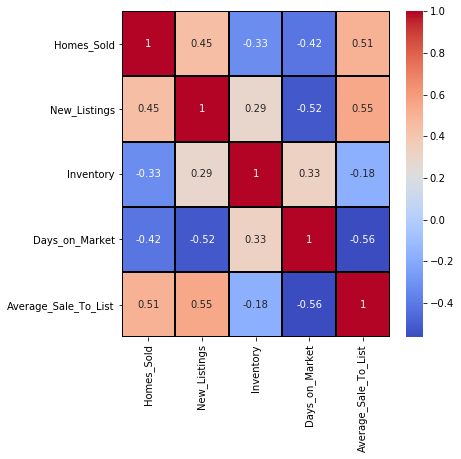

In [103]:
fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm', linewidth=1, linecolor='black')

# High std 1

In [104]:
laurelhurst_df = neighborhood_df.loc[neighborhood_df.index == " Laurelhurst"]
laurelhurst_df.reset_index(drop=True, inplace=True)
laurelhurst_df.set_index("Month_of_Period_End", inplace = True)

In [105]:
adfuller(laurelhurst_df.Median_Sale_Price)

(-2.95278851866222,
 0.039544807756693945,
 0,
 104,
 {'1%': -3.4948504603223145,
  '5%': -2.889758398668639,
  '10%': -2.5818220155325444},
 1193.0531672015927)

In [106]:
laurelhurst_df['Returns'] = laurelhurst_df.Median_Sale_Price.pct_change()
laurelhurst_df = laurelhurst_df.dropna()

C:\Users\Sravani\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [107]:
train = laurelhurst_df.iloc[:94,:] 
test = laurelhurst_df.iloc[95:,:]

Comparison_h1 = pd.DataFrame()
#Comparison.index = test.index
Comparison_h1["Original"] = (test.loc[:, 'Returns'])
Returns = train.loc[:, 'Returns']

In [108]:
model = ARMA(Returns.values, order=(1,1))
results = model.fit()

In [109]:
predicted_arma = results.forecast(steps=9)[0]
Comparison_h1["Arma"] = predicted_arma

In [110]:
model = ARIMA(Returns, order=(1, 1, 1))
results = model.fit()

C:\Users\Sravani\anaconda3\envs\pyvizenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Sravani\anaconda3\envs\pyvizenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [111]:
predicted_arima = results.forecast(steps=9)[0]
Comparison_h1["Arima"] = predicted_arma

In [112]:
model = arch_model(Returns, mean="Zero", vol="GARCH", p=1, q=1)
res = model.fit(disp="off")

C:\Users\Sravani\anaconda3\envs\pyvizenv\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0243. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


In [113]:
forecast_horizon = 9
garch = res.forecast(horizon=forecast_horizon)
intermediate = np.sqrt(garch.variance.dropna() * 252)
final = intermediate.dropna().T
final.columns = ["Garch"]
final.index = Comparison_h1.index
Comparison_h1["Garch"] = final["Garch"]

In [114]:
Comparison_h1.hvplot().opts(xrotation=90)

:NdOverlay   [Variable]
   :Curve   [Month_of_Period_End]   (value)

In [115]:
X = laurelhurst_df[["Homes_Sold", "New_Listings","Inventory", "Days_on_Market", "Average_Sale_To_List" ]].copy()
y = laurelhurst_df["Median_Sale_Price"].ravel()
y[:5]

array([ 953, 1013,  886,  738,  775], dtype=int64)

In [116]:
xtrain = X.iloc[:94,:] 
xtest = X.iloc[95:,:]

ytrain = y[0:94]
ytest = y[95::]

In [117]:
scaler = StandardScaler()

In [118]:
X_scaler = scaler.fit(xtrain)
X_train_scaled = X_scaler.transform(xtrain)
X_test_scaled = X_scaler.transform(xtest)

In [119]:
rf_model = RandomForestClassifier(n_estimators=500, random_state=78)
rf_model = rf_model.fit(X_train_scaled, ytrain)
predictions = rf_model.predict(X_test_scaled)

In [120]:
importances = rf_model.feature_importances_

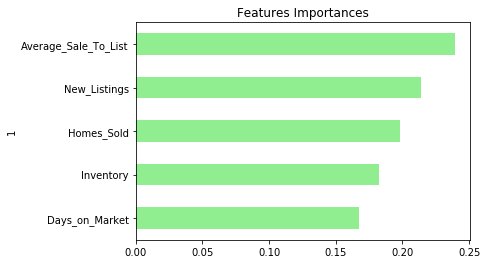

In [121]:
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)

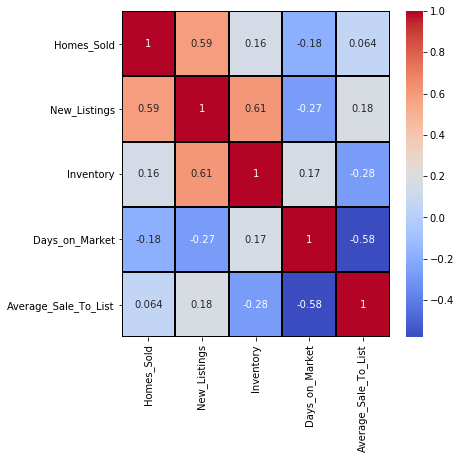

In [122]:
fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm', linewidth=1, linecolor='black')

# high std 2

In [123]:
madisonpark_df = neighborhood_df.loc[neighborhood_df.index == " Madison Park"]
madisonpark_df.reset_index(drop=True, inplace=True)
madisonpark_df.set_index("Month_of_Period_End", inplace = True)

In [124]:
adfuller(madisonpark_df.Median_Sale_Price)

(-1.9390312863332095,
 0.31392809436925534,
 4,
 100,
 {'1%': -3.497501033, '5%': -2.89090644, '10%': -2.5824349},
 1214.1208699417962)

In [125]:
madisonpark_df['Returns'] = madisonpark_df.Median_Sale_Price.pct_change()
madisonpark_df = madisonpark_df.dropna()

C:\Users\Sravani\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [126]:
train = madisonpark_df.iloc[:94,:] 
test = madisonpark_df.iloc[95:,:]

Comparison_h2 = pd.DataFrame()
#Comparison.index = test.index
Comparison_h2["Original"] = (test.loc[:, 'Returns'])
Returns = train.loc[:, 'Returns']

In [127]:
model = ARMA(Returns.values, order=(1,1))
results = model.fit()

In [128]:
predicted_arma = results.forecast(steps=9)[0]
Comparison_h2["Arma"] = predicted_arma

In [129]:
model = ARIMA(Returns, order=(1, 1, 1))
results = model.fit()

C:\Users\Sravani\anaconda3\envs\pyvizenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Sravani\anaconda3\envs\pyvizenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [130]:
predicted_arima = results.forecast(steps=9)[0]
Comparison_h2["Arima"] = predicted_arma
Comparison_h2

,Original,Arma,Arima
Month_of_Period_End,,,
February 2020,-0.146052,0.036308,0.036308
March 2020,-0.156601,0.030544,0.030544
April 2020,-0.062104,0.026614,0.026614
May 2020,-0.121622,0.023934,0.023934
June 2020,0.230769,0.022107,0.022107
July 2020,-0.187500,0.020861,0.020861
August 2020,0.346154,0.020012,0.020012
September 2020,-0.142857,0.019433,0.019433
October 2020,0.178667,0.019038,0.019038


In [131]:
model = arch_model(Returns, mean="Zero", vol="GARCH", p=1, q=1)
res = model.fit(disp="off")

C:\Users\Sravani\anaconda3\envs\pyvizenv\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.02498. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


In [132]:
forecast_horizon = 9
garch = res.forecast(horizon=forecast_horizon)
intermediate = np.sqrt(garch.variance.dropna() * 252)
final = intermediate.dropna().T
final.columns = ["Garch"]
final.index = Comparison_h2.index
Comparison_h2["Garch"] = final["Garch"]

In [133]:
Comparison_h2.hvplot().opts(xrotation=90)

:NdOverlay   [Variable]
   :Curve   [Month_of_Period_End]   (value)

In [134]:
X = madisonpark_df[["Homes_Sold", "New_Listings","Inventory", "Days_on_Market", "Average_Sale_To_List" ]].copy()
y = madisonpark_df["Median_Sale_Price"].ravel()
y[:5]

array([ 994, 1225,  872,  840,  766], dtype=int64)

In [135]:
xtrain = X.iloc[:94,:] 
xtest = X.iloc[95:,:]

ytrain = y[0:94]
ytest = y[95::]

In [136]:
scaler = StandardScaler()

In [137]:
X_scaler = scaler.fit(xtrain)
X_train_scaled = X_scaler.transform(xtrain)
X_test_scaled = X_scaler.transform(xtest)

In [138]:
rf_model = RandomForestClassifier(n_estimators=500, random_state=78)
rf_model = rf_model.fit(X_train_scaled, ytrain)
predictions = rf_model.predict(X_test_scaled)

In [139]:
importances = rf_model.feature_importances_

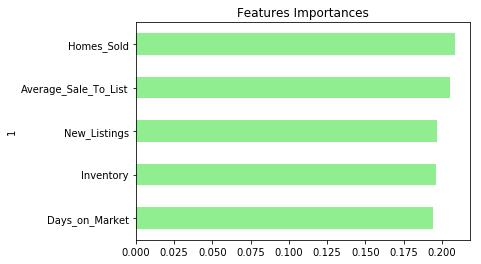

In [140]:
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)

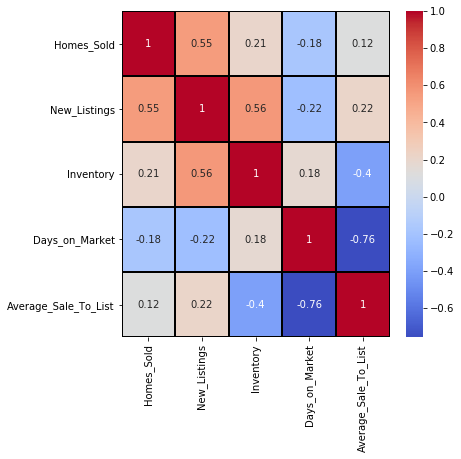

In [141]:
fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm', linewidth=1, linecolor='black')

# High std 3

In [142]:
portagebay_df = neighborhood_df.loc[neighborhood_df.index == " Portage Bay"]
portagebay_df.reset_index(drop=True, inplace=True)
portagebay_df.set_index("Month_of_Period_End", inplace = True)

In [143]:
adfuller(portagebay_df.Median_Sale_Price)

(-1.6399896322584808,
 0.46226621027576614,
 6,
 98,
 {'1%': -3.4989097606014496,
  '5%': -2.891516256916761,
  '10%': -2.5827604414827157},
 1259.0397225443028)

In [144]:
portagebay_df['Returns'] = portagebay_df.Median_Sale_Price.pct_change()
portagebay_df = portagebay_df.dropna()

C:\Users\Sravani\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [145]:
train = portagebay_df.iloc[:94,:] 
test = portagebay_df.iloc[95:,:]

Comparison_h3 = pd.DataFrame()
#Comparison.index = test.index
Comparison_h3["Original"] = (test.loc[:, 'Returns'])
Returns = train.loc[:, 'Returns']

In [146]:
model = ARMA(Returns.values, order=(1,1))
results = model.fit()

In [147]:
predicted_arma = results.forecast(steps=9)[0]
Comparison_h3["Arma"] = predicted_arma

In [148]:
model = ARIMA(Returns, order=(1, 1, 1))
results = model.fit()

C:\Users\Sravani\anaconda3\envs\pyvizenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Sravani\anaconda3\envs\pyvizenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [149]:
predicted_arima = results.forecast(steps=9)[0]
Comparison_h3["Arima"] = predicted_arma

In [150]:
model = arch_model(Returns, mean="Zero", vol="GARCH", p=1, q=1)
res = model.fit(disp="off")

In [151]:
forecast_horizon = 9
garch = res.forecast(horizon=forecast_horizon)
intermediate = np.sqrt(garch.variance.dropna() * 252)
final = intermediate.dropna().T
final.columns = ["Garch"]
final.index = Comparison_h3.index
Comparison_h3["Garch"] = final["Garch"]

In [152]:
Comparison_h3.hvplot().opts(xrotation=90)

:NdOverlay   [Variable]
   :Curve   [Month_of_Period_End]   (value)

In [153]:
X = portagebay_df[["Homes_Sold", "New_Listings","Inventory", "Days_on_Market", "Average_Sale_To_List" ]].copy()
y = portagebay_df["Median_Sale_Price"].ravel()
y[:5]

array([705, 761, 743, 761, 613], dtype=int64)

In [154]:
xtrain = X.iloc[:94,:] 
xtest = X.iloc[95:,:]

ytrain = y[0:94]
ytest = y[95::]

In [155]:
scaler = StandardScaler()

In [156]:
X_scaler = scaler.fit(xtrain)
X_train_scaled = X_scaler.transform(xtrain)
X_test_scaled = X_scaler.transform(xtest)

In [157]:
rf_model = RandomForestClassifier(n_estimators=500, random_state=78)
rf_model = rf_model.fit(X_train_scaled, ytrain)
predictions = rf_model.predict(X_test_scaled)

In [158]:
importances = rf_model.feature_importances_

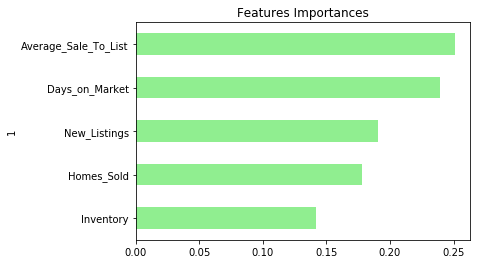

In [159]:
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)

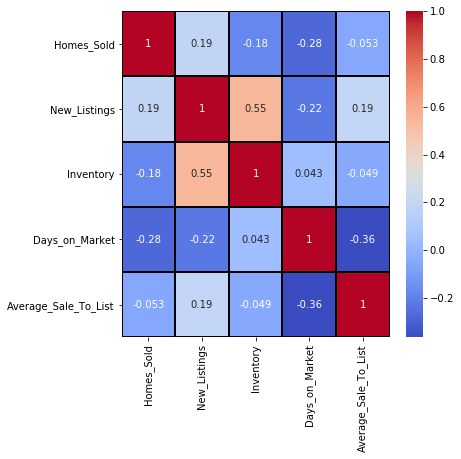

In [160]:
fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm', linewidth=1, linecolor='black')

# High std 4

In [161]:
seattlecentralbusinessdistrict_df = neighborhood_df.loc[neighborhood_df.index == " Seattle Central Business District"]
seattlecentralbusinessdistrict_df.reset_index(drop=True, inplace=True)
seattlecentralbusinessdistrict_df.set_index("Month_of_Period_End", inplace = True)

In [162]:
adfuller(seattlecentralbusinessdistrict_df.Median_Sale_Price)

(-1.8142448535705582,
 0.3734128036480285,
 0,
 104,
 {'1%': -3.4948504603223145,
  '5%': -2.889758398668639,
  '10%': -2.5818220155325444},
 1418.6080531170487)

In [163]:
seattlecentralbusinessdistrict_df['Returns'] = seattlecentralbusinessdistrict_df.Median_Sale_Price.pct_change()
seattlecentralbusinessdistrict_df = seattlecentralbusinessdistrict_df.dropna()

C:\Users\Sravani\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [164]:
train = seattlecentralbusinessdistrict_df.iloc[:94,:] 
test = seattlecentralbusinessdistrict_df.iloc[95:,:]

Comparison_h4 = pd.DataFrame()
#Comparison.index = test.index
Comparison_h4["Original"] = (test.loc[:, 'Returns'])
Returns = train.loc[:, 'Returns']

In [165]:
model = ARMA(Returns.values, order=(1,1))
results = model.fit()

In [166]:
predicted_arma = results.forecast(steps=9)[0]
Comparison_h4["Arma"] = predicted_arma

In [167]:
model = ARIMA(Returns, order=(1, 0, 1))
results = model.fit()

C:\Users\Sravani\anaconda3\envs\pyvizenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [168]:
predicted_arima = results.forecast(steps=9)[0]
Comparison_h4["Arima"] = predicted_arma

In [169]:
model = arch_model(Returns, mean="Zero", vol="GARCH", p=1, q=1)
res = model.fit(disp="off")

C:\Users\Sravani\anaconda3\envs\pyvizenv\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04838. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


In [170]:
forecast_horizon = 9
garch = res.forecast(horizon=forecast_horizon)
intermediate = np.sqrt(garch.variance.dropna() * 252)
final = intermediate.dropna().T
final.columns = ["Garch"]
final.index = Comparison_h4.index
Comparison_h4["Garch"] = final["Garch"]

In [171]:
Comparison_h4.hvplot().opts(xrotation=90)

:NdOverlay   [Variable]
   :Curve   [Month_of_Period_End]   (value)

In [172]:
X = seattlecentralbusinessdistrict_df[["Homes_Sold", "New_Listings","Inventory", "Days_on_Market", "Average_Sale_To_List" ]].copy()
y = seattlecentralbusinessdistrict_df["Median_Sale_Price"].ravel()
y[:5]

array([290, 485, 442, 442, 442], dtype=int64)

In [173]:
xtrain = X.iloc[:94,:] 
xtest = X.iloc[95:,:]

ytrain = y[0:94]
ytest = y[95::]

In [174]:
scaler = StandardScaler()

In [175]:
X_scaler = scaler.fit(xtrain)
X_train_scaled = X_scaler.transform(xtrain)
X_test_scaled = X_scaler.transform(xtest)

In [176]:
rf_model = RandomForestClassifier(n_estimators=500, random_state=78)
rf_model = rf_model.fit(X_train_scaled, ytrain)
predictions = rf_model.predict(X_test_scaled)

In [177]:
importances = rf_model.feature_importances_

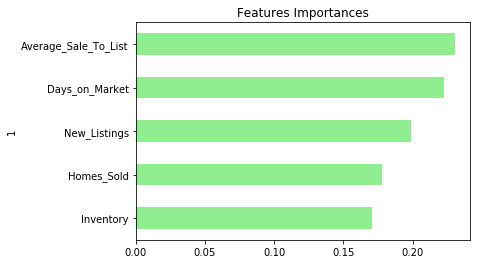

In [178]:
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)

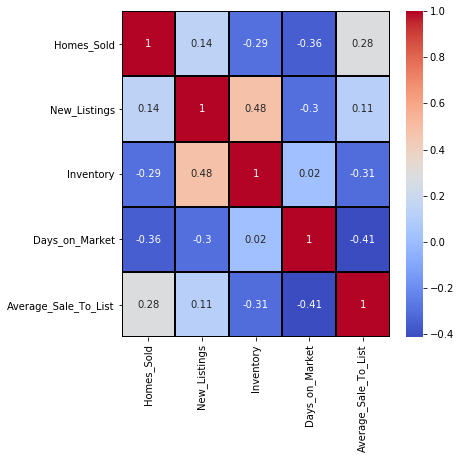

In [179]:
fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm', linewidth=1, linecolor='black')

# high std 5

In [180]:
dennyblaine_df = neighborhood_df.loc[neighborhood_df.index == " Denny Blaine"]
dennyblaine_df.reset_index(drop=True, inplace=True)
dennyblaine_df.set_index("Month_of_Period_End", inplace = True)

In [181]:
adfuller(dennyblaine_df.Median_Sale_Price)

(-0.6221719303729878,
 0.8658929665460824,
 8,
 96,
 {'1%': -3.5003788874873405,
  '5%': -2.8921519665075235,
  '10%': -2.5830997960069446},
 1396.2157235992831)

In [182]:
dennyblaine_df['Returns'] = dennyblaine_df.Median_Sale_Price.pct_change()
dennyblaine_df = dennyblaine_df.dropna()

C:\Users\Sravani\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [183]:
train = dennyblaine_df.iloc[:94,:] 
test = dennyblaine_df.iloc[95:,:]

Comparison_h5 = pd.DataFrame()
#Comparison.index = test.index
Comparison_h5["Original"] = (test.loc[:, 'Returns'])
Returns = train.loc[:, 'Returns']

In [184]:
model = ARMA(Returns.values, order=(1,1))
results = model.fit()

In [185]:
predicted_arma = results.forecast(steps=9)[0]
Comparison_h5["Arma"] = predicted_arma

In [186]:
model = ARIMA(Returns, order=(1, 1, 1))
results = model.fit()

C:\Users\Sravani\anaconda3\envs\pyvizenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Sravani\anaconda3\envs\pyvizenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [187]:
predicted_arima = results.forecast(steps=9)[0]
Comparison_h5["Arima"] = predicted_arma

In [188]:
model = arch_model(Returns, mean="Zero", vol="GARCH", p=1, q=1)
res = model.fit(disp="off")

C:\Users\Sravani\anaconda3\envs\pyvizenv\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08657. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


In [189]:
forecast_horizon = 9
garch = res.forecast(horizon=forecast_horizon)
intermediate = np.sqrt(garch.variance.dropna() * 252)
final = intermediate.dropna().T
final.columns = ["Garch"]
final.index = Comparison_h5.index
Comparison_h5["Garch"] = final["Garch"]

In [190]:
Comparison_h5.hvplot().opts(xrotation=90)

:NdOverlay   [Variable]
   :Curve   [Month_of_Period_End]   (value)

In [191]:
X = dennyblaine_df[["Homes_Sold", "New_Listings","Inventory", "Days_on_Market", "Average_Sale_To_List" ]].copy()
y = dennyblaine_df["Median_Sale_Price"].ravel()
y[:5]

array([1438, 1438, 1398, 1138, 1200], dtype=int64)

In [192]:
xtrain = X.iloc[:94,:] 
xtest = X.iloc[95:,:]

ytrain = y[0:94]
ytest = y[95::]

In [193]:
scaler = StandardScaler()

In [194]:
X_scaler = scaler.fit(xtrain)
X_train_scaled = X_scaler.transform(xtrain)
X_test_scaled = X_scaler.transform(xtest)

In [195]:
rf_model = RandomForestClassifier(n_estimators=500, random_state=78)
rf_model = rf_model.fit(X_train_scaled, ytrain)
predictions = rf_model.predict(X_test_scaled)

In [196]:
importances = rf_model.feature_importances_

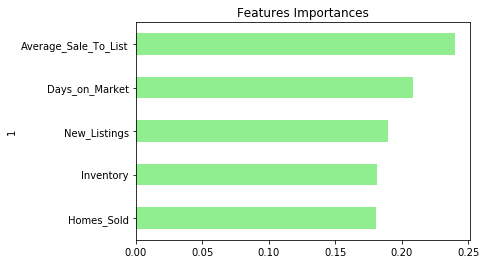

In [197]:
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)

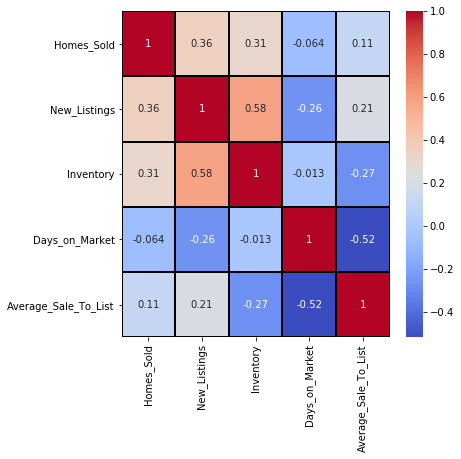

In [198]:
fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm', linewidth=1, linecolor='black')